Notice: [Errno 2] No such file or directory: 'stock_data.csv'. Generating dummy data for demonstration...
ARIMA -> MAE: 2.8053, RMSE: 3.6023, MAPE: 2.7842%
VARMAX -> MAE: 4.8912, RMSE: 6.0239, MAPE: 4.8598%
GARCH (on Returns) -> MAE: 1.0244, RMSE: 1.2783, MAPE: 217.8970%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
LSTM -> MAE: 1.4552, RMSE: 1.7973, MAPE: 1.4533%


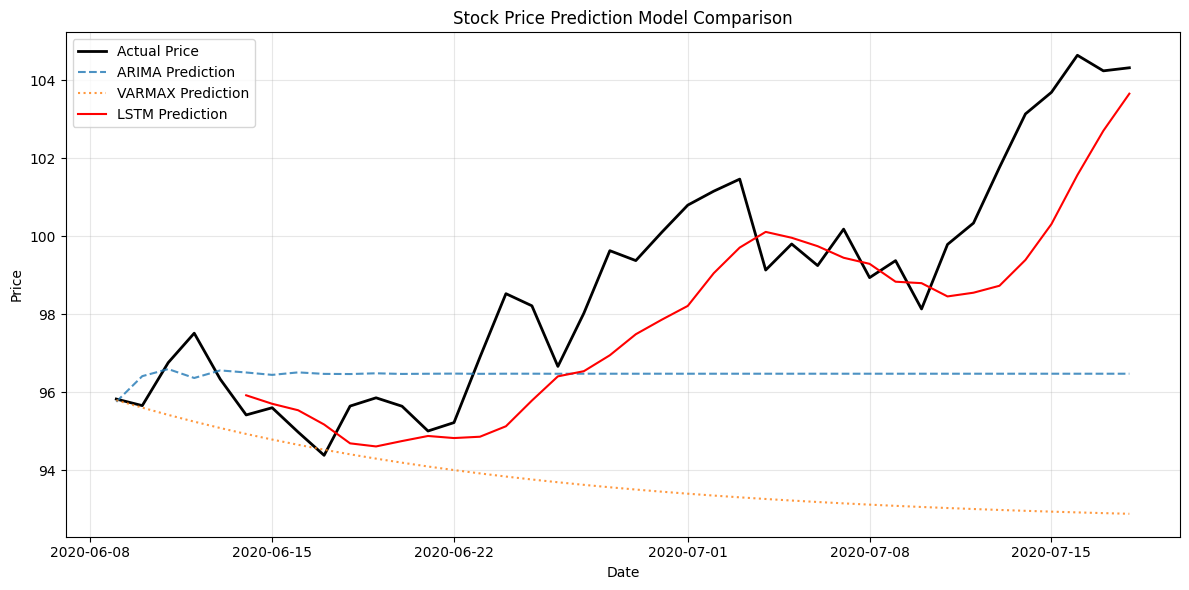

In [3]:
# -------------------- 1. INSTALL DEPENDENCIES --------------------
!pip install arch

# -------------------- 2. IMPORT LIBRARIES --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings

warnings.filterwarnings('ignore')

# -------------------- 3. LOAD & PREPARE DATA --------------------
try:
    df = pd.read_csv("stock_data.csv", parse_dates=['Date'], index_col='Date')
    df.columns = [c.title() for c in df.columns]
    if 'Close' not in df.columns:
        raise ValueError("The CSV must have a 'Close' column.")
    df = df[['Close']].copy()
    df['Returns'] = df['Close'].pct_change()
    df.dropna(inplace=True)
except Exception as e:
    print(f"Notice: {e}. Generating dummy data for demonstration...")
    dates = pd.date_range(start='2020-01-01', periods=200, freq='D')
    close_prices = 100 + np.cumsum(np.random.randn(200) + 0.05)
    df = pd.DataFrame({'Close': close_prices}, index=dates)
    df['Returns'] = df['Close'].pct_change()
    df.dropna(inplace=True)

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# -------------------- 4. EVALUATION FUNCTION --------------------
def evaluate(y_true, y_pred, model_name):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    print(f"{model_name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%")
    return mae, rmse, mape

# -------------------- 5. ARIMA MODEL --------------------
arima_model = ARIMA(train['Close'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))
evaluate(test['Close'], arima_pred, "ARIMA")

# -------------------- 6. VARMAX MODEL (STABILITY & ATTR FIX) --------------------
# Use StandardScaler to handle different magnitudes of Close and Returns
var_scaler = StandardScaler()
train_scaled_var = var_scaler.fit_transform(train[['Close', 'Returns']])
train_scaled_var_df = pd.DataFrame(train_scaled_var, index=train.index, columns=['Close', 'Returns'])

var_model = VARMAX(train_scaled_var_df, order=(1, 0))

# FIX: Access the internal state-space model to initialize as diffuse
# This bypasses the Schur Decomposition / LinAlgError
var_model.ssm.initialize_diffuse()

# Using 'powell' optimizer for better convergence on multi-variate data
var_fit = var_model.fit(maxiter=100, disp=False, method='powell')

# Forecast
var_forecast_obj = var_fit.get_forecast(steps=len(test))
var_forecast_scaled = var_forecast_obj.summary_frame()

# Inverse transform to get back to actual price scale
# We need to map the forecast back to the 2-column shape the scaler expects
var_pred_raw = var_forecast_scaled[['mean']].values
dummy_forecast = np.zeros((len(test), 2))
dummy_forecast[:, 0] = var_pred_raw[:, 0] # First column is Close
var_pred_final = var_scaler.inverse_transform(dummy_forecast)[:, 0]
var_pred = pd.Series(var_pred_final, index=test.index)

evaluate(test['Close'], var_pred, "VARMAX")

# -------------------- 7. GARCH MODEL --------------------
returns_train = train['Returns'] * 100
returns_test = test['Returns'] * 100
garch_model = arch_model(returns_train, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
garch_forecast = garch_fit.forecast(horizon=len(returns_test), reindex=False)
garch_pred = garch_forecast.mean.values[-1, :] + np.sqrt(garch_forecast.variance.values[-1, :])
evaluate(returns_test, garch_pred, "GARCH (on Returns)")

# -------------------- 8. LSTM MODEL --------------------
lstm_scaler = MinMaxScaler()
train_scaled_lstm = lstm_scaler.fit_transform(train[['Close']])
test_scaled_lstm = lstm_scaler.transform(test[['Close']])

def create_sequences(data, seq_len=5):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_len = 5
X_train, y_train = create_sequences(train_scaled_lstm, seq_len)
X_test, y_test = create_sequences(test_scaled_lstm, seq_len)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

nn_model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

nn_pred = nn_model.predict(X_test)
nn_pred_inv = lstm_scaler.inverse_transform(nn_pred)
y_test_inv = lstm_scaler.inverse_transform(y_test.reshape(-1, 1))
evaluate(y_test_inv, nn_pred_inv, "LSTM")

# -------------------- 9. VISUALIZATION --------------------
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual Price', color='black', lw=2)
plt.plot(test.index, arima_pred.values, label='ARIMA Prediction', alpha=0.8, linestyle='--')
plt.plot(test.index, var_pred.values, label='VARMAX Prediction', alpha=0.8, linestyle=':')
plt.plot(test.index[seq_len:], nn_pred_inv, label='LSTM Prediction', color='red', lw=1.5)
plt.title('Stock Price Prediction Model Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()